In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv('2021-06-24_Casos_Covid_19_-_Base_de_Dados.csv', sep=';')
df.columns = ['notification_date', 'class', 'age', 'gender', 'district', 'death_date', 'status', 'foo']
df.drop(columns='foo', inplace=True)
df

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,notification_date,class,age,gender,district,death_date,status
0,11/03/2020,CONFIRMADO,54,M,DSMZ,NaN,RECUPERADO
1,12/03/2020,CONFIRMADO,43,M,DSBQ,NaN,RECUPERADO
2,12/03/2020,CONFIRMADO,15,M,DSBQ,NaN,RECUPERADO
3,12/03/2020,CONFIRMADO,25,F,DSMZ,NaN,RECUPERADO
4,12/03/2020,CONFIRMADO,58,M,DSMZ,NaN,RECUPERADO
...,...,...,...,...,...,...,...
234120,19/06/2021,CONFIRMADO,63,F,DSBQ,NaN,NaN
234121,19/06/2021,CONFIRMADO,67,F,DSMZ,NaN,NaN
234122,19/06/2021,CONFIRMADO,55,F,NaN,NaN,NaN
234123,21/06/2021,CONFIRMADO,58,M,DSCJ,21/06/2021,�BITO CONF


In [3]:
print("Shape: ", df.shape)

Shape:  (234125, 7)


In [4]:
print("Unique values in every column \n"+'-'*25)
for i in df.columns:
    print("\t"+i+" = ",len(set(df[i])))

Unique values in every column 
-------------------------
	notification_date =  467
	class =  1
	age =  762
	gender =  6
	district =  11
	death_date =  417
	status =  3


Looks like the `class` attribute is unecessary, since it only has one kind of value that repeats all over the dataset, so we will drop it.

In [5]:
df.drop(columns=['class'], inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234125 entries, 0 to 234124
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   notification_date  234125 non-null  object
 1   age                234123 non-null  object
 2   gender             234125 non-null  object
 3   district           221052 non-null  object
 4   death_date         5984 non-null    object
 5   status             226193 non-null  object
dtypes: object(6)
memory usage: 10.7+ MB


In [7]:
df.describe().T

,count,unique,top,freq
notification_date,234125,467,08/03/2021,2836
age,234123,760,38,3099
gender,234125,6,F,126086
district,221052,10,DSBV,33620
death_date,5984,416,29/03/2021,54
status,226193,2,RECUPERADO,220209


In [8]:
df.isnull().sum()

notification_date         0
age                       2
gender                    0
district              13073
death_date           228141
status                 7932
dtype: int64

In [9]:
# drop null age rows
df.dropna(subset = ["age"], inplace=True)
print(df.isnull().sum())

notification_date         0
age                       0
gender                    0
district              13073
death_date           228139
status                 7932
dtype: int64


In [10]:
# district has too many data for dropping, and since it is a categoric type
# we'll just switch NaNs with UNKNOWN label
districts = []
for district in df.district.values:
    if district is np.nan:
        districts.append('UNKNOWN')
    else:
        districts.append(district)
df['district'] = districts

In [11]:
# all ages to int
ages = []
for i in df.age.values:
    try:
        age = int(i)
    except ValueError as e:
        age = int(float(str(i).replace(',', '.')))
    except Exception as e:
        print(e)
        age = i
    ages.append(age)
df['age'] = ages

In [12]:
# all genders to binary

def gender_2bin(char):
    return 1 if char.lower() == 'm' else 0

genders = [gender_2bin(char) for char in df.gender.values]
df['gender'] = genders

In [13]:
df[['recovered', 'dead']] = pd.get_dummies(df['status'])
df.drop(columns=['status'], inplace=True)
df

,notification_date,age,gender,district,death_date,recovered,dead
0,11/03/2020,54,1,DSMZ,NaN,1,0
1,12/03/2020,43,1,DSBQ,NaN,1,0
2,12/03/2020,15,1,DSBQ,NaN,1,0
3,12/03/2020,25,0,DSMZ,NaN,1,0
4,12/03/2020,58,1,DSMZ,NaN,1,0
...,...,...,...,...,...,...,...
234120,19/06/2021,63,0,DSBQ,NaN,0,0
234121,19/06/2021,67,0,DSMZ,NaN,0,0
234122,19/06/2021,55,0,UNKNOWN,NaN,0,0
234123,21/06/2021,58,1,DSCJ,21/06/2021,0,1


In [14]:
print('Number of deaths: ', len([i for i in df.dead if i == 1]))
print('Number of recovered: ', len([i for i in df.dead if i == 0]))

Number of deaths:  5984
Number of recovered:  228139


In [15]:
try:
    df['notification_date'] = pd.to_datetime(df['notification_date'])
    df['notification_year'] = df['notification_date'].dt.year
    df['notification_month'] = df.notification_date.dt.month
except:
    pass

try:
    df['death_date'] = pd.to_datetime(df['death_date'])
    df['death_year'] = df['death_date'].dt.year
    df['death_month'] = df.death_date.dt.month
except:
    pass
df.head()

,notification_date,age,gender,district,death_date,recovered,dead,notification_year,notification_month,death_year,death_month
0,2020-11-03,54,1,DSMZ,NaT,1,0,2020,11,NaN,NaN
1,2020-12-03,43,1,DSBQ,NaT,1,0,2020,12,NaN,NaN
2,2020-12-03,15,1,DSBQ,NaT,1,0,2020,12,NaN,NaN
3,2020-12-03,25,0,DSMZ,NaT,1,0,2020,12,NaN,NaN
4,2020-12-03,58,1,DSMZ,NaT,1,0,2020,12,NaN,NaN


In [16]:
print('Notification months : ', sorted(df['notification_month'].unique()))
print('Notification years   : ', sorted(df['notification_year'].unique()))

Notification months :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Notification years   :  [2020, 2021]


In [17]:
print('Death months : ', sorted(df['death_month'].unique()))
print('Death years   : ', sorted(df['death_year'].unique()))

Death months :  [nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
Death years   :  [nan, 2020.0, 2021.0]


In [18]:
print("Age -> \n"+"-"*30)
print("\tTotal Count    = ", df['age'].shape[0])
print("\tMinimum Value  = ", df['age'].min())
print("\tMaximum Value  = ",df['age'].max())
print("\tMean Value     = ",df['age'].mean())
print("\tStd dev Value  = ",df['age'].std())
print("\tVariance Value = ",df['age'].var())


Age -> 
------------------------------
	Total Count    =  234123
	Minimum Value  =  0
	Maximum Value  =  107
	Mean Value     =  39.95222596669272
	Std dev Value  =  17.469078917373672
	Variance Value =  305.1687182214293


In [19]:
# tradução das siglas identificadas em:
# https://www.curitiba.pr.gov.br/servicos/enderecos-da-vigilancia-sanitaria-municipal/729
district_map = {
    'DSMZ': 'Matriz',
    'DSBQ': 'Boqueirão',
    'DSPR': 'Portão',
    'DSBV': 'Boa Vista',
    'DSSF': 'Santa Felicidade',
    'DSCJ': 'Cajuru',
    'DSPN': 'Pinheirinho',
    'DSCIC': 'CIC',
    'DSBN': 'Bairro Novo',
    'DSTQ': 'Tatuquara'
}

districts_geomap = {
    'DSMZ': (-25.4307842, -49.3039002),
    'DSBQ': (-25.5054148, -49.2529249),
    'DSPR': (-25.4720321, -49.3185196),
    'DSBV': (-25.3863067, -49.2645271),
    'DSSF': (-25.3953506, -49.364192),
    'DSCJ': (-25.4613033, -49.2268961),
    'DSPN': (-25.5238141, -49.3104457),
    'DSCIC': (-25.4945581, -49.4133876),
    'DSBN': (-25.5710449, -49.3092243),
    'DSTQ': (-25.5606956, -49.33638)
}

In [20]:
lats, longs = [], []
for value in df.district.values:
    if value in districts_geomap:
        lt, lg = districts_geomap.get(value)
        lats.append(lt)
        longs.append(lg)
    else:
        lats.append(np.nan)
        longs.append(np.nan)

assert len(lats) == len(longs) == len(df.district)
df['latitude'] = lats
df['longitude'] = longs

In [21]:
df['district'].value_counts()

DSBV       33620
DSCIC      26463
DSBQ       23942
DSCJ       23690
DSPN       21367
DSPR       21237
DSBN       20044
DSMZ       18458
DSSF       17879
DSTQ       14350
UNKNOWN    13073
Name: district, dtype: int64

In [22]:
district_counts = []
district_count_map =  Counter(df['district'].values)
for district in df.district.values:
    if district in district_count_map:
        district_counts.append(district_count_map.get(district))
    else:
        district_counts.append(df.district.isnull().sum())

assert len(district_counts) == len(df)
df['region_ocurrences'] = district_counts

df[['district', 'region_ocurrences']].value_counts()

district  region_ocurrences
DSBV      33620                33620
DSCIC     26463                26463
DSBQ      23942                23942
DSCJ      23690                23690
DSPN      21367                21367
DSPR      21237                21237
DSBN      20044                20044
DSMZ      18458                18458
DSSF      17879                17879
DSTQ      14350                14350
UNKNOWN   13073                13073
dtype: int64

In [23]:
district_death_count = {}

for row in df[['district', 'dead']].values:
    district, dead = row
    if dead == 1:
        if district in district_death_count:
            district_death_count[district] += 1
        else:
            district_death_count[district] = 1

print(district_death_count)

{'DSBV': 896, 'DSBQ': 696, 'DSCJ': 762, 'DSPR': 518, 'DSSF': 477, 'DSPN': 606, 'DSMZ': 560, 'DSBN': 524, 'DSCIC': 648, 'DSTQ': 295, 'UNKNOWN': 2}


In [24]:
region_death_count = []

for district in df.district.values:
    if district in district_death_count:
        region_death_count.append(district_death_count.get(district))

assert len(region_death_count) == len(df)
df['district_death_count'] = region_death_count

In [25]:
for row in df[['dead', 'notification_year', 'death_year', 'notification_month', 'death_month']].values:
    if row[0] == 1 and row[1] == 2020:
        print(row)
# print(df.columns)
# print(df.values[0][2])

[1.00e+00 2.02e+03 2.02e+03 3.00e+00 4.00e+00]
[1.00e+00 2.02e+03 2.02e+03 3.00e+00 6.00e+00]
[1.00e+00 2.02e+03 2.02e+03 3.00e+00 4.00e+00]
[1.00e+00 2.02e+03 2.02e+03 3.00e+00 4.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.00e+00 4.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.00e+00 6.00e+00]
[1.00e+00 2.02e+03 2.02e+03 2.00e+00 5.00e+00]
[1.00e+00 2.02e+03 2.02e+03 2.00e+00 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 2.00e+00 4.00e+00]
[1.00e+00 2.02e+03 2.02e+03 3.00e+00 4.00e+00]
[1.00e+00 2.02e+03 2.02e+03 4.00e+00 4.00e+00]
[1.00e+00 2.02e+03 2.02e+03 4.00e+00 2.00e+00]
[1.00e+00 2.02e+03 2.02e+03 5.00e+00 4.00e+00]
[1.00e+00 2.02e+03 2.02e+03 5.00e+00 4.00e+00]
[1.00e+00 2.02e+03 2.02e+03 6.00e+00 4.00e+00]
[1.00e+00 2.02e+03 2.02e+03 6.00e+00 4.00e+00]
[1.00e+00 2.02e+03 2.02e+03 7.00e+00 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 7.00e+00 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 8.00e+00 5.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.00e+01 5.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 7.00e+00]
[1.00e+00 2.0

[1.00e+00 2.02e+03 2.02e+03 1.00e+01 6.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.20e+01]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 1.00e+01]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 9.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 7.00e+00 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 7.00e+00 6.00e+00]
[1.00e+00 2.02e+03 2.02e+03 7.00e+00 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 7.00e+00 8.00e+00]
[1.00e+00 2.0

[1.00e+00 2.02e+03 2.02e+03 4.00e+00 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 5.00e+00 3.00e+00]
[1.00e+00 2.02e+03 2.02e+03 5.00e+00 1.20e+01]
[1.00e+00 2.02e+03 2.02e+03 5.00e+00 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 5.00e+00 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 5.00e+00 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 5.00e+00 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 5.00e+00 1.00e+01]
[1.00e+00 2.02e+03 2.02e+03 5.00e+00 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 5.00e+00 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 5.00e+00 5.00e+00]
[1.00e+00 2.02e+03 2.02e+03 6.00e+00 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 6.00e+00 1.00e+00]
[1.00e+00 2.02e+03 2.02e+03 6.00e+00 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 6.00e+00 1.20e+01]
[1.00e+00 2.02e+03 2.02e+03 6.00e+00 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 6.00e+00 3.00e+00]
[1.00e+00 2.02e+03 2.02e+03 6.00e+00 5.00e+00]
[1.00e+00 2.02e+03 2.02e+03 6.00e+00 5.00e+00]
[1.00e+00 2.02e+03 2.02e+03 6.00e+00 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 6.00e+00 8.00e+00]
[1.00e+00 2.0

[1.00e+00 2.02e+03 2.02e+03 9.00e+00 9.00e+00]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 9.00e+00]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 1.00e+01]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 1.00e+01]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 1.00e+01]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 1.00e+01]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 1.00e+01]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 9.00e+00]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 9.00e+00]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 9.00e+00]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 9.00e+00]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 1.00e+01]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 9.00e+00]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 8.00e+00]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 1.00e+01]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 7.00e+00]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 6.00e+00]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 9.00e+00]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 9.00e+00]
[1.00e+00 2.02e+03 2.02e+03 9.00e+00 1.00e+01]
[1.00e+00 2.0

[1.00e+00 2.02e+03 2.02e+03 1.10e+01 3.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.00e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.20e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.20e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.20e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.20e+01]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 3.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.10e+01]
[1.00e+00 2.0

[1.00e+00 2.02e+03 2.02e+03 1.10e+01 9.00e+00]
[1.00e+00 2.02e+03 2.02e+03 1.10e+01 1.20e+01]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 1.20e+01]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 1.20e+01]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 1.00e+01]
[1.000e+00 2.020e+03 2.021e+03 1.200e+01 1.000e+00]
[1.000e+00 2.020e+03 2.021e+03 1.200e+01 1.000e+00]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 1.20e+01]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 1.20e+01]
[1.000e+00 2.020e+03 2.021e+03 1.200e+01 5.000e+00]
[1.000e+00 2.020e+03 2.021e+03 1.200e+01 7.000e+00]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 1.20e+01]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 1.20e+01]
[1.000e+00 2.020e+03 2.021e+03 1.200e+01 5.000e+00]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 1.10e+01]
[1.000e+00 2.020e+03 2.021e+03 1.200e+01 3.000e+00]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 1.20e+01]
[1.000e+00 2.020e+03 2.021e+03 1.200e+01 1.000e+00]
[1.000e+00 2.020e+03 2.021e+03 1.200e+01 1.000e+00]
[1.00e+00 2.02e+03 2.02e+03 1.20e+01 1.20e+01]
[1.00e+00 2.02e+03 2

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


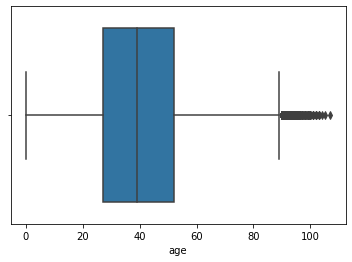

In [26]:
sns.boxplot(df['age'])
plt.show()

In [27]:
dfcorr = df.corr()
dfcorr

,age,gender,recovered,dead,notification_year,notification_month,death_year,death_month,latitude,longitude,region_ocurrences,district_death_count
age,1.000000,-0.020155,-0.179320,0.245641,-0.002461,-0.014265,-0.193223,0.063245,0.055401,0.030281,0.021046,0.039514
gender,-0.020155,1.000000,-0.031439,0.033646,0.008149,-0.007002,-0.000972,0.000252,0.007125,0.003340,-0.005514,-0.004969
recovered,-0.179320,-0.031439,1.000000,-0.644250,-0.143944,0.012120,NaN,NaN,-0.026433,-0.027181,-0.039535,-0.046280
dead,0.245641,0.033646,-0.644250,1.000000,0.015138,-0.024073,NaN,NaN,0.004972,0.011699,0.018040,0.033228
notification_year,-0.002461,0.008149,-0.143944,0.015138,1.000000,-0.521549,0.938708,-0.457947,0.010060,0.014243,0.030415,0.019856
notification_month,-0.014265,-0.007002,0.012120,-0.024073,-0.521549,1.000000,-0.426713,0.306990,-0.000995,0.003272,-0.006477,-0.010538
death_year,-0.193223,-0.000972,NaN,NaN,0.938708,-0.426713,1.000000,-0.507221,-0.006496,-0.013279,0.030072,0.018359
death_month,0.063245,0.000252,NaN,NaN,-0.457947,0.306990,-0.507221,1.000000,0.022150,0.023581,-0.003674,0.002919
latitude,0.055401,0.007125,-0.026433,0.004972,0.010060,-0.000995,-0.006496,0.022150,1.000000,0.183982,0.511808,0.543633
longitude,0.030281,0.003340,-0.027181,0.011699,0.014243,0.003272,-0.013279,0.023581,0.183982,1.000000,0.267013,0.521113


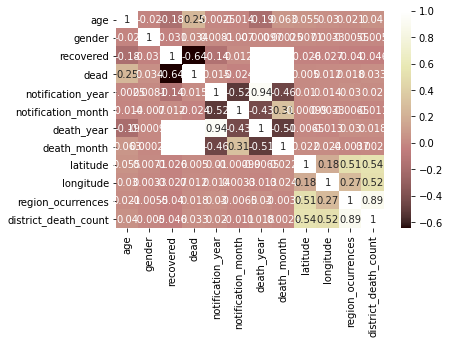

In [28]:
sns.heatmap(dfcorr, annot=True, cmap='pink')
plt.show()

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dead', ylabel='count'>

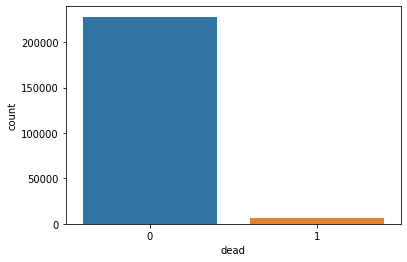

In [29]:
sns.countplot(df['dead'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='notification_year', ylabel='count'>

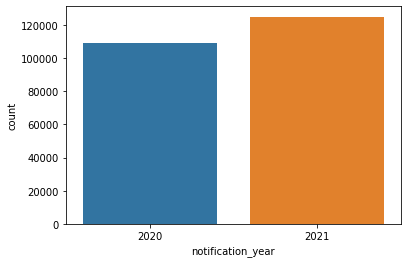

In [30]:
sns.countplot(df['notification_year'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='death_year', ylabel='count'>

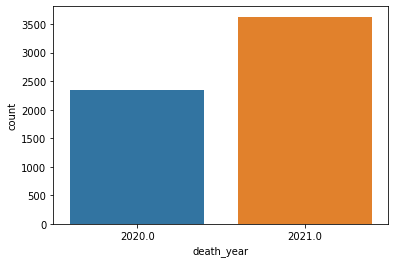

In [31]:
sns.countplot(df['death_year'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='death_month', ylabel='count'>

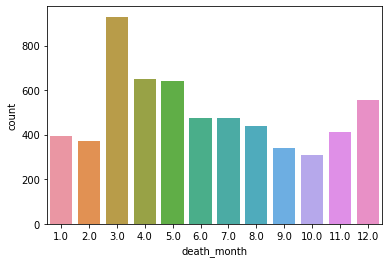

In [32]:
sns.countplot(df['death_month'])

In [33]:
# TODO: Dividir em épocas do ano [jan-mar, abr-jun, jul-set, out-dez]


/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

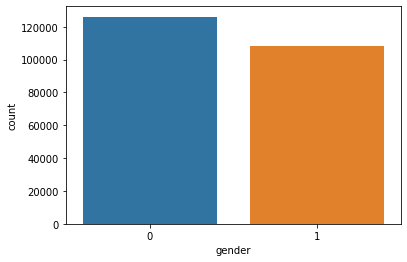

In [34]:
sns.countplot(df['gender'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='district_death_count', ylabel='count'>

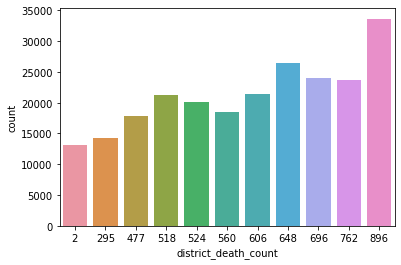

In [35]:
sns.countplot(df['district_death_count'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='gender'>

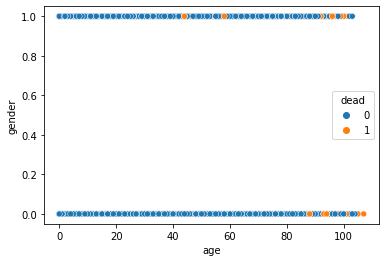

In [36]:
sns.scatterplot(df['age'], df['gender'],hue=df['dead'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='district', ylabel='age'>

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


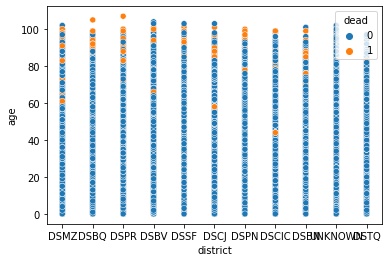

In [37]:
sns.scatterplot(df['district'], df['age'],hue=df['dead'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='death_month', ylabel='notification_year'>

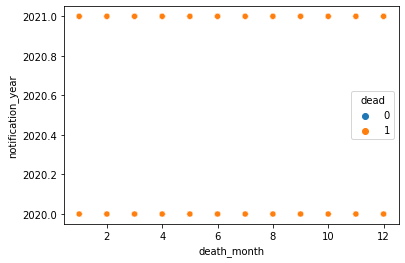

In [38]:
sns.scatterplot(df['death_month'], df['notification_year'],hue=df['dead'])

<AxesSubplot:ylabel='Frequency'>

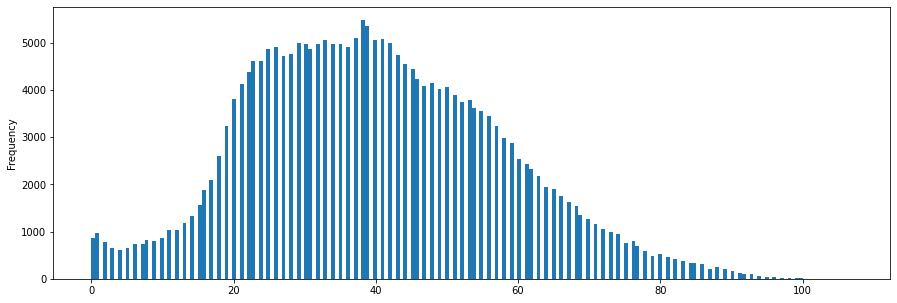

In [39]:
df.age.plot.hist(figsize=(15, 5), bins=200)

<AxesSubplot:>

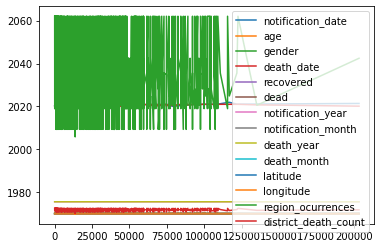

In [40]:
# deaths_per_month = []
df.loc[(df['death_date'] >= '2020-01-01') &
               (df['death_date'] < '2021-01-01')].plot()



In [41]:
twok20_deaths = df.loc[(df['death_date'] >= '2020-01-01') &
               (df['death_date'] < '2021-01-01')]

deathcount_2020_month = Counter([int(i) for i in twok20_deaths.death_month.values])

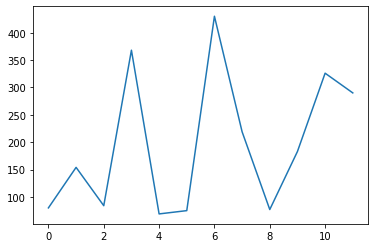

In [42]:
plt.plot(deathcount_2020_month.values())

In [43]:
twok21_deaths = df.loc[(df['death_date'] >= '2021-01-01')]
deathcount_2021_month = Counter([int(i) for i in twok21_deaths.death_month.values])

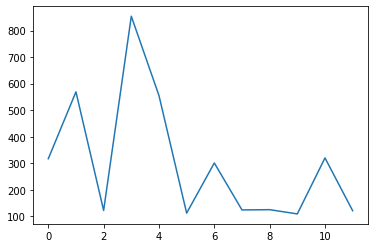

In [44]:
plt.plot(deathcount_2021_month.values())

In [45]:
twok20_male_deaths = df.loc[(df['death_date'] >= '2020-01-01') &
               (df['death_date'] < '2021-01-01') & df['gender'] == 1]

twok20_female_deaths = df.loc[(df['death_date'] >= '2020-01-01') &
               (df['death_date'] < '2021-01-01') & df['gender'] == 0]

# 
# print()


In [46]:
male_deathcount_2020_month = Counter([int(i) for i in twok20_male_deaths.death_month.values])
# female_deathcount_2020_month = Counter([int(i) for i in twok20_female_deaths.death_month.values])
# plt.plot(male_deathcount_2020_month.values())

In [47]:
twok20_female_deaths.death_month.values

array([nan, nan, nan, ..., nan,  6.,  6.])

array([[<AxesSubplot:title={'center':'notification_date'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'death_date'}>],
       [<AxesSubplot:title={'center':'recovered'}>,
        <AxesSubplot:title={'center':'dead'}>,
        <AxesSubplot:title={'center':'notification_year'}>,
        <AxesSubplot:title={'center':'notification_month'}>],
       [<AxesSubplot:title={'center':'death_year'}>,
        <AxesSubplot:title={'center':'death_month'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'region_ocurrences'}>,
        <AxesSubplot:title={'center':'district_death_count'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

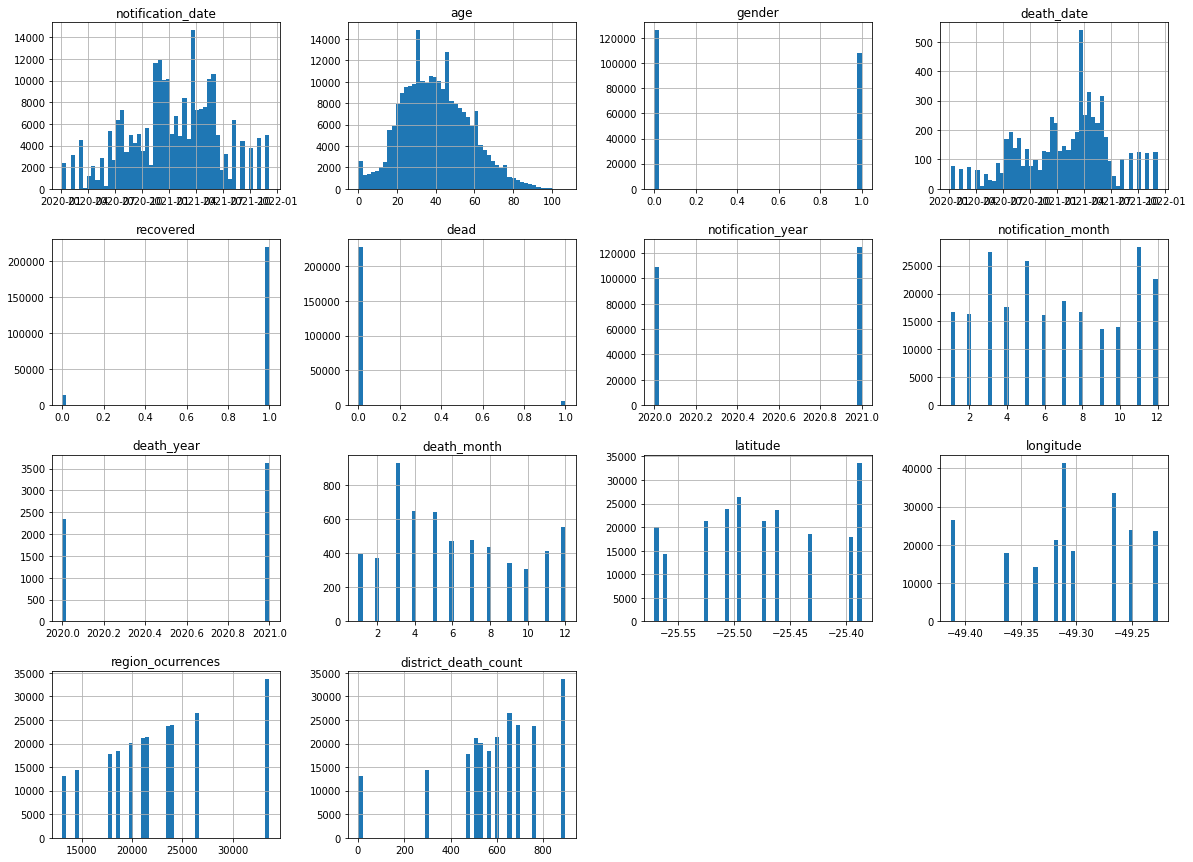

In [48]:
df.hist(bins=50, figsize=(20, 15))

<AxesSubplot:>

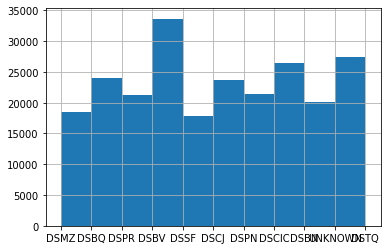

In [49]:
df['district'].hist()

<BarContainer object of 11 artists>

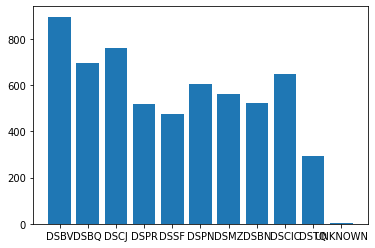

In [50]:
plt.bar(district_death_count.keys(), district_death_count.values())

In [51]:
encoder = OneHotEncoder()
encoded_district, district_labels = df['district'].factorize()
district_1hot = encoder.fit_transform(encoded_district.reshape(-1, 1))

In [52]:
print('Encoded District: ', encoded_district)
print('____________________________________')
print('Hot encoding: ', district_1hot[:10])
print('____________________________________')
print('Labels: ', ' '.join(label for label in district_labels))

Encoded District:  [0 1 1 ... 9 5 7]
____________________________________
Hot encoding:    (0, 0)	1.0
  (1, 1)	1.0
  (2, 1)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 2)	1.0
  (6, 3)	1.0
  (7, 0)	1.0
  (8, 3)	1.0
  (9, 0)	1.0
____________________________________
Labels:  DSMZ DSBQ DSPR DSBV DSSF DSCJ DSPN DSCIC DSBN UNKNOWN DSTQ


In [53]:
cat_encoder = OrdinalEncoder()
imputer = SimpleImputer(missing_values=np.nan, strategy='median')


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_encoder', cat_encoder),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

df_nums = num_pipeline.fit_transform(
    df[['age', 'gender', 'recovered', 'dead', 'region_ocurrences', 'district_death_count']]
)
df_cat = cat_pipeline.fit_transform(df['district'].values.reshape(-1, 1))

In [54]:
df_cat


array([[ 0.19163778],
       [-1.15550156],
       [-1.15550156],
       ...,
       [ 1.87556196],
       [-0.14514705],
       [-0.48193189]])

In [55]:
cat_encoder.categories_

[array(['DSBN', 'DSBQ', 'DSBV', 'DSCIC', 'DSCJ', 'DSMZ', 'DSPN', 'DSPR',
        'DSSF', 'DSTQ', 'UNKNOWN'], dtype=object)]

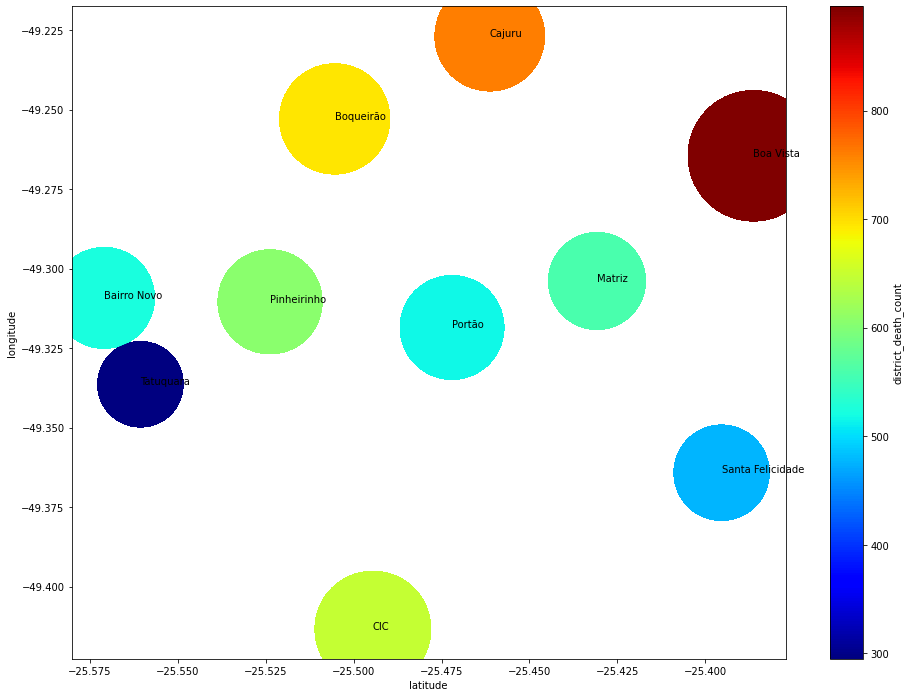

In [56]:
fig, ax = plt.subplots()

df.plot(kind='scatter', x='latitude', y='longitude',
             s=df['region_ocurrences']/2, figsize=(16, 12), ax=ax,
             c='district_death_count', cmap=plt.get_cmap('jet'), colorbar=True)

for district, latlong in districts_geomap.items():
    ax.annotate(district_map.get(district), latlong)

plt.show()

In [57]:
x = pd.DataFrame(df_nums, columns=['age', 'gender', 'recovered', 'dead',
                                   'region_ocurrences', 'district_death_count'])
x['district'] = df_cat
xdeads = x['dead']
xrecs = x['recovered']
x.drop(['dead', 'recovered'], inplace=True, axis=1)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(x, xdeads)

In [59]:
X_train

,age,gender,region_ocurrences,district_death_count,district
232702,0.346200,-0.925639,0.175724,0.786532,-0.145147
181295,1.147617,1.080335,0.219871,0.473605,-1.155502
121251,1.376594,1.080335,-0.842288,-0.564744,1.201992
205483,0.517932,1.080335,-1.460523,-1.427664,1.538777
191155,-1.199392,-0.925639,-0.254010,-0.370350,0.865207
...,...,...,...,...,...
17767,-0.798683,-0.925639,-0.740855,-0.171215,0.191638
53908,-0.054509,-0.925639,0.661518,0.246021,-0.481932
191869,1.204861,-0.925639,1.915332,1.421868,-0.818717
213146,0.918641,1.080335,0.219871,0.473605,-1.155502


In [60]:
# treinando um modelo
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [61]:
y_preds = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, y_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.9401796590457148

In [62]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

tree_preds = tree_reg.predict(X_test)

tree_mse = mean_squared_error(y_test, tree_preds)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.9325734222475051

In [63]:
scores = cross_val_score(tree_reg, x, xdeads,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [64]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Std deviation: ', scores.std())

In [65]:
display_scores(tree_rmse_scores)

Scores:  [1.13738029 0.91980108 0.83682643 0.69513769 0.82616633 0.93522811
 1.17308597 1.1195786  1.02506055 0.76508469]
Mean:  0.9433349740281791
Std deviation:  0.1572409530769659


In [66]:
forest_reg = DecisionTreeRegressor()
forest_reg.fit(X_train, y_train)
forest_predictions = forest_reg.predict(X_test)

forest_mse = mean_squared_error(y_test, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, x, xdeads,
                         scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

0.9324533203310525


In [67]:
display_scores(forest_rmse_scores)

Scores:  [1.13738029 0.91980108 0.83682643 0.69513769 0.82616633 0.93522811
 1.17308597 1.1195786  1.02506055 0.76508469]
Mean:  0.9433349740281791
Std deviation:  0.1572409530769659


In [68]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 3]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x, xdeads)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 3], 'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [69]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [70]:
x['dead'] = xdeads
x['recovered'] = xrecs
x

,age,gender,region_ocurrences,district_death_count,district,dead,recovered
0,0.804153,1.080335,-0.740855,-0.171215,0.191638,-0.161956,0.251386
1,0.174467,1.080335,0.219871,0.473605,-1.155502,-0.161956,0.251386
2,-1.428368,1.080335,0.219871,0.473605,-1.155502,-0.161956,0.251386
3,-0.855927,-0.925639,-0.740855,-0.171215,0.191638,-0.161956,0.251386
4,1.033129,1.080335,-0.740855,-0.171215,0.191638,-0.161956,0.251386
...,...,...,...,...,...,...,...
234118,1.319350,-0.925639,0.219871,0.473605,-1.155502,-0.161956,-3.977941
234119,1.548326,-0.925639,-0.740855,-0.171215,0.191638,-0.161956,-3.977941
234120,0.861397,-0.925639,-1.684237,-2.816870,1.875562,-0.161956,-3.977941
234121,1.033129,1.080335,0.175724,0.786532,-0.145147,6.174531,-3.977941


In [71]:
cluster = KMeans(n_clusters=4)

In [72]:
cluster.fit(x)

KMeans(n_clusters=4)

In [73]:
cluster_labels = cluster.labels_
Counter(cluster_labels)

Counter({1: 84155, 2: 99456, 0: 44528, 3: 5984})

In [74]:
metrics.silhouette_score(x, cluster_labels, metric='euclidean')

0.28269794935819215

In [75]:
# find better cluster size
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(x)
    silhouette = metrics.silhouette_score(x, labels, metric='euclidean')
    print(f'{i}: silhouette: {silhouette}')

2: silhouette: 0.2634774336962081
3: silhouette: 0.2940361948206824
4: silhouette: 0.27210583625930734
5: silhouette: 0.31335554715086306
6: silhouette: 0.3219208079630378
7: silhouette: 0.33036706821775436
8: silhouette: 0.3407387360567246
9: silhouette: 0.333175924454741


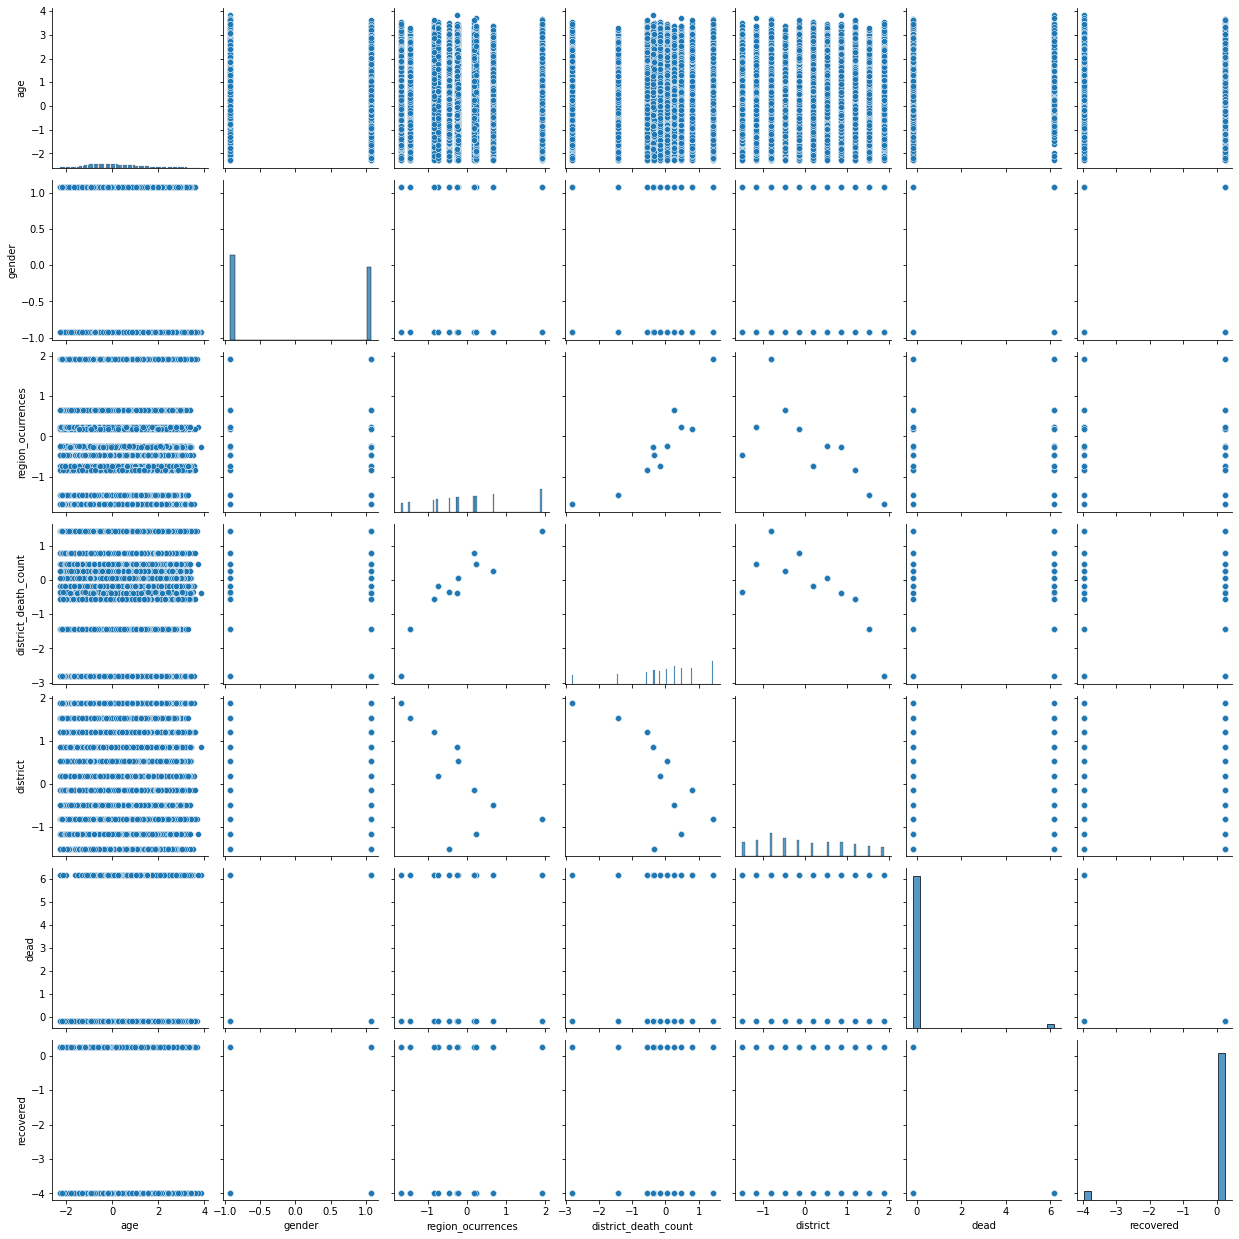

In [76]:
sns.pairplot(x)

<AxesSubplot:xlabel='age', ylabel='district'>

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


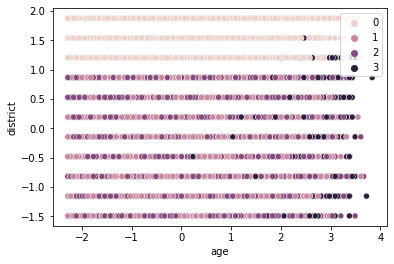

In [77]:
sns.scatterplot(x=x['age'], y=x['district'], hue=cluster.labels_)

<AxesSubplot:xlabel='age', ylabel='district_death_count'>

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


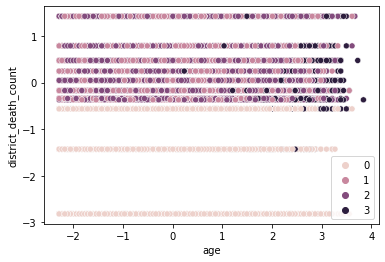

In [78]:
sns.scatterplot(x=x['age'], y=x['district_death_count'], hue=cluster.labels_)

In [79]:
from sklearn.neighbors import KernelDensity

# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X_train)
kde.score_samples(X_test)

array([-1.3137232 , -1.55374737, -1.1587658 , ..., -2.83190641,
       -1.62454208, -1.83203373])

In [80]:
#https://en.wikipedia.org/wiki/Gaussian_function
def gaussian(x, b=1):
    return np.exp(-x**2 / (2*b**2)) / (b*np.sqrt(2*np.pi))

gaussian(X_train[['region_ocurrences', 'district_death_count']]).std().median() * 100

11.965944674328908

In [81]:
https://publicacoes.ifc.edu.br/index.php/metapre/article/view/1312/1020

SyntaxError: invalid syntax (<ipython-input-81-20f8fde3186b>, line 1)